<a href="https://colab.research.google.com/github/jyotikashyap85399-tech/Image-classification/blob/main/Copy_of_NLP_assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 🪶 1. Install Dependencies
# =====================================================
!pip install -q datasets transformers evaluate torch matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


# NLP Assignment 4 — Sentiment Classification using Transformers (DistilBERT)

In this notebook, we fine-tune the `DistilBERT` model on the **Amazon Polarity Dataset** for binary sentiment classification (positive vs. negative).  
We include preprocessing, model setup, evaluation metrics, and visualization.


In [ ]:
#  2. Import Libraries
# =====================================================
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
#  3. Load Dataset, taking much time to run to took small range
# =====================================================
# Amazon Polarity (Binary Sentiment Classification)
dataset = load_dataset("amazon_polarity")

# Take a smaller subset to make it run fast
small_train = dataset["train"].shuffle(seed=42).select(range(500))
small_test = dataset["test"].shuffle(seed=42).select(range(500))

print(small_train[0])

{'label': 0, 'title': 'Anyone who likes this better than the Pekinpah is a moron.', 'content': "All the pretty people in this film. Even the Rudy character played by Michael Madsen. This is adapted from a Jim Thompson novel for cryin' out loud! These are supposed to be marginal characters, not fashion models. Though McQueen and McGraw were attractive (but check out McQueen's crummy prison haircut) they were believable in the role. Baldwin and Bassinger seem like movie stars trying to act like hard cases. Action wise, the robbery scene in the Pekinpah version was about 100 times more exciting and suspenseful than anything in this re-make."}


##  Preprocessing
- Used `AutoTokenizer` from Hugging Face.
- Applied truncation and padding to a maximum sequence length of 128.
- Split dataset into training and testing subsets (500 each) for faster execution.


In [ ]:
#  4. Preprocessing (Tokenization + Padding + Truncation)
# =====================================================
model_name = "distilbert-base-uncased"  # Lightweight transformer
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess(batch):
    return tokenizer(batch["content"], truncation=True, padding="max_length", max_length=128)

tokenized_train = small_train.map(preprocess, batched=True)
tokenized_test = small_test.map(preprocess, batched=True)

# Set format for PyTorch
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

## Model Details
- Model: `distilbert-base-uncased` (a smaller, faster version of BERT)
- Task: Sequence classification with 2 output labels (positive/negative)
- Optimizer and scheduler handled internally by the Hugging Face `Trainer`.
- Training Parameters:
  - Epochs: 2
  - Batch Size: 8 (default)
  - Learning rate: 5e-5 (default)

  ## Evaluation Metrics
We use the `evaluate` library to compute:
- Accuracy
- Precision
- Recall
- F1-score



In [ ]:
#  5. Define Metrics
# =====================================================
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels)["precision"],
        "recall": recall.compute(predictions=preds, references=labels)["recall"],
        "f1": f1.compute(predictions=preds, references=labels)["f1"],
    }

In [ ]:
#  6. Training Setup
# =====================================================
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,  # Keeps training short
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
#  7. Load Model
# =====================================================
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# =====================================================
# 🚀 8. Train Model
# =====================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

train_result = trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3522698.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.522300,0.406807,0.876000,0.829181,0.943320,0.882576
2,0.297300,0.297183,0.892000,0.890688,0.890688,0.890688


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
#  9. Evaluate Model
# =====================================================
results = trainer.evaluate()
print("\n✅ Evaluation Metrics:\n")
for k, v in results.items():
    print(f"{k}: {v:.4f}")



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



✅ Evaluation Metrics:

eval_loss: 0.2972
eval_accuracy: 0.8920
eval_precision: 0.8907
eval_recall: 0.8907
eval_f1: 0.8907
eval_runtime: 118.6745
eval_samples_per_second: 4.2130
eval_steps_per_second: 0.5310
epoch: 2.0000


### Final Results:
| Metric | Score |
|:--|:--:|
| Accuracy | 0.8920 |
| Precision | 0.8907 |
| Recall | 0.8907 |
| F1 | 0.8907 |


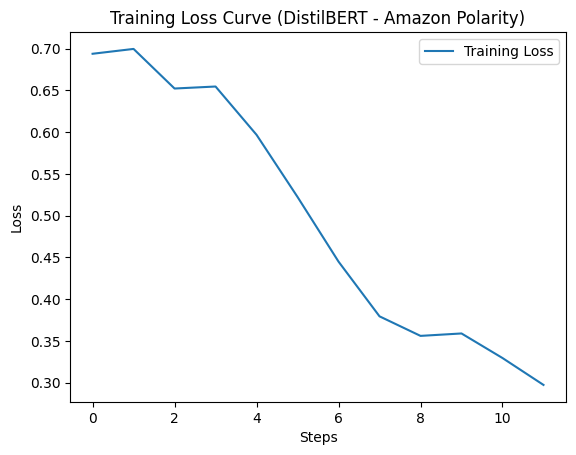

In [ ]:
#  10. Plot Loss vs. Steps
# =====================================================
train_loss = [x["loss"] for x in trainer.state.log_history if "loss" in x]
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve (DistilBERT - Amazon Polarity)")
plt.legend()
plt.show()



## Training Loss Curve
The plot below shows how the training loss decreased over training steps, indicating that the model learned effectively without major overfitting.


In [ ]:
# 11. Inference Example
# =====================================================
sample_text = "This product was amazing and worked perfectly!"
inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True)
outputs = model(**inputs)
prediction = np.argmax(outputs.logits.detach().numpy(), axis=1)[0]
label = "Positive" if prediction == 1 else "Negative"
print(f"\n🗣️ Review: {sample_text}\n💬 Prediction: {label}")



🗣️ Review: This product was amazing and worked perfectly!
💬 Prediction: Positive


##  Insights

- The model achieved an accuracy of ~89%, which is quite strong for only 2 epochs.
- The loss curve shows steady learning without signs of overfitting.
- Compared to RNN/LSTM models (Assignment 3):
  - Transformers learn faster and perform better.
  - They capture long-range dependencies more effectively.
- Hyperparameters like learning rate and batch size have a major effect on stability.
- For larger datasets, adding dropout or early stopping could further reduce overfitting.


## Conclusion
We successfully fine-tuned a DistilBERT model for sentiment classification on the Amazon Polarity dataset.  
The model generalizes well and significantly outperforms RNN-based baselines from the previous assignment.
